### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import odc.geo.xr
from datacube.utils.cog import write_cog
import netCDF4
import h5py
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from dea_tools.plotting import xr_animation
import shapely
from dea_tools.spatial import xr_vectorize
import cmocean

### boxes

In [18]:
boxes_vec = gpd.read_file('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.geojson')

In [46]:
boxes = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.nc')

In [26]:
boxes_25 = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes_25km.nc')

### Ice motion

In [5]:
ds = xr.open_dataset('/g/data/gv90/P6_data/NSIDC/NSIDC-0116/icemotion_weekly_sh_25km_20190101_20191231_v4.1.nc')

In [6]:
ds = ds.sel(time=slice("2019-06-01", "2019-08-31")).groupby('time.month').mean(dim='time')

In [7]:
ds = ds.rename({'u':'u-','v':'v-'})

In [8]:
ds = ds.mean(dim='month')

In [9]:
crop = ds.where((ds.x > -3000000) & (ds.x < 0) & (ds.y > 500000) & (ds.y < 3000000), drop=True)
crop = crop.coarsen({'x':4}, boundary='trim').mean().coarsen({'y':4}, boundary='trim').mean()

### 3 month mean MYI - 2019

In [11]:
# 3 month mean - 2019 - ice types uncorrected
icetype = xr.open_dataset('/g/data/gv90/sc0554/2019_junjulaug_mean_IceTypesUncorrected.nc')
# icetype = icetype.where((icetype['YI'] > 15) | (icetype['FYI'] > 15) | (icetype['MYI'] > 15) | (icetype['TOTAL_ICE'] > 15))
icetype_crop=icetype.where((icetype.Y > -3000000) & (icetype.Y < 0) & (icetype.X > 500000) & (icetype.X < 3000000), drop=True)
icetype_crop = icetype_crop.drop('spatial_ref')

# multiple icetype subplots

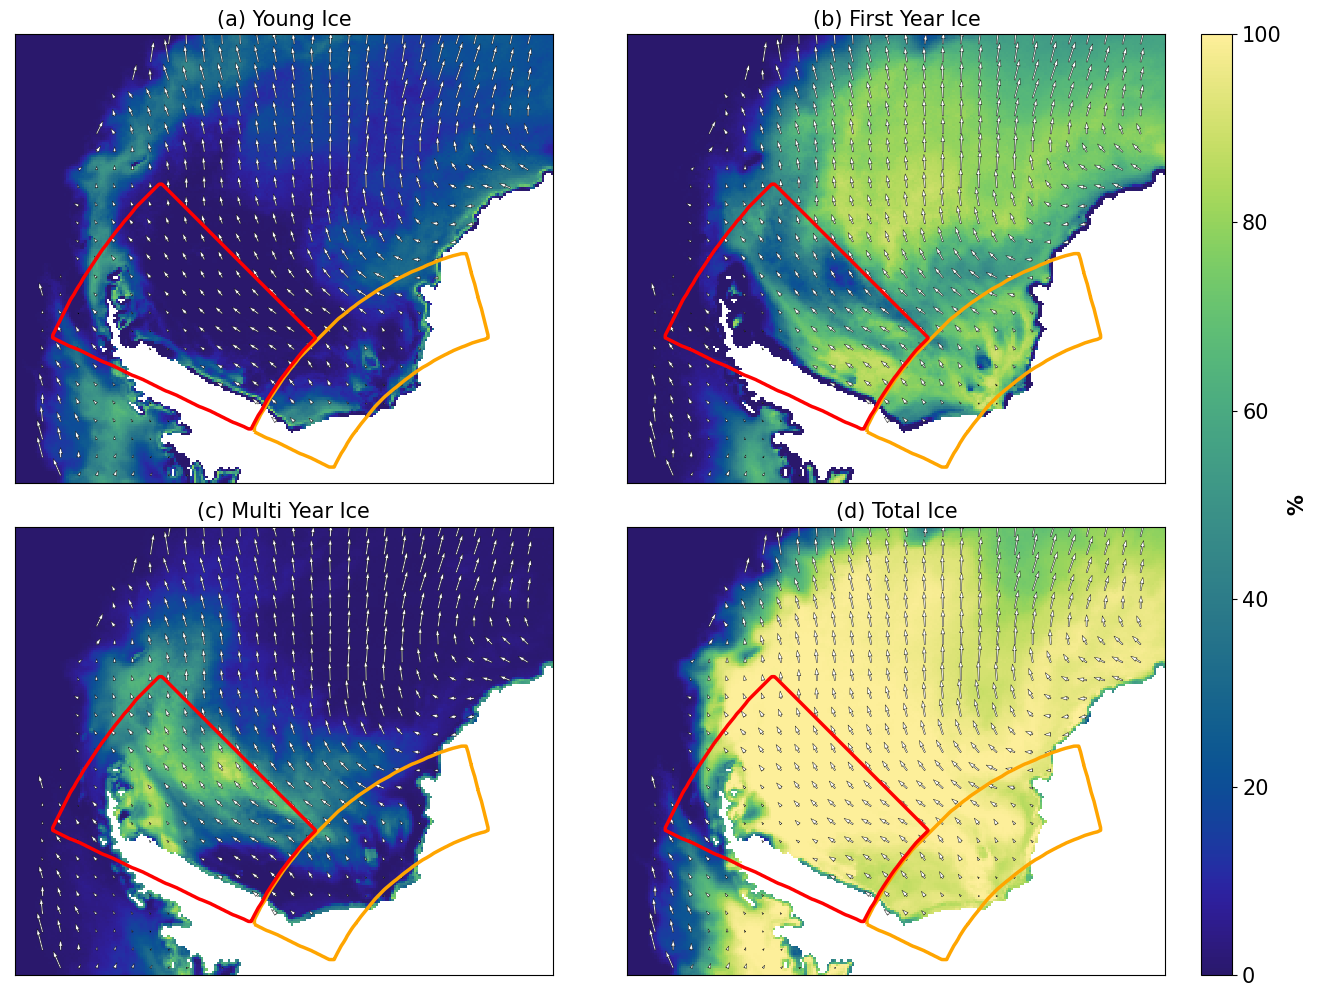

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
cmap = cmocean.cm.haline
box_colours = ['orange','r']
plt.tight_layout()  
fig.tight_layout()

[axi.xaxis.set_visible(False) for axi in ax.ravel()]
[axi.yaxis.set_visible(False) for axi in ax.ravel()]

a = icetype_crop['YI'].plot(cmap=cmap, ax=ax[0, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,0], linewidth=2.5)
quiver = ax[0,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[0,0].set_title('(a) Young Ice', fontsize=15)

icetype_crop['FYI'].plot(cmap=cmap, ax=ax[0, 1], vmin=0, vmax=100, add_colorbar=False,)
boxes_vec.boundary.plot(color=box_colours, ax=ax[0,1], linewidth=2.5)
quiver = ax[0,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[0,1].set_title('(b) First Year Ice', fontsize=15)

icetype_crop['MYI'].plot(cmap=cmap, ax=ax[1, 0], add_colorbar=False, vmin=0, vmax=100)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,0], linewidth=2.5)
quiver = ax[1,0].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[1,0].set_title('(c) Multi Year Ice', fontsize=15)

icetype_crop['TOTAL_ICE'].plot(cmap=cmap, ax=ax[1, 1], vmin=0, vmax=100,add_colorbar=False)
boxes_vec.boundary.plot(color=box_colours, ax=ax[1,1], linewidth=2.5)
quiver = ax[1,1].quiver(crop['x'], crop['y'],crop['u-'], crop['v-'], color='white', edgecolors='black', linewidth=0.3)
ax[1,1].set_title('(d) Total Ice', fontsize=15)

cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025)
# cbar = plt.colorbar(a,ax=ax.ravel().tolist(),aspect=30, pad=0.025,orientation='horizontal', extend='max')
cbar.set_label(label="%", size=15,weight='bold')
cbar.ax.tick_params(labelsize=15)

# plt.savefig('/g/data/jk72/sc0554/icemotion.png', dpi=300, bbox_inches='tight')
plt.show()

### Timeseries analysis and plotting

In [49]:
# Load Daily Ice type data
ds = xr.open_dataset('/g/data/gv90/sc0554/2018_2022_IceTypesUncorrected.nc', chunks='auto')
ds = ds.rename_dims({'X':'x','Y':'y'})
ds = ds.rename({'X':'x', 'Y':'y'})

# Resample to weekly
resampled = ds.resample(time='W').mean()
resampled = resampled.drop('spatial_ref')

In [24]:
# Load Monthly IS2 data
ATL20 = xr.open_dataset('/g/data/jk72/sc0554/ATL20_new.nc', chunks='auto')

# swap dimensions of ATL20 to match boxes
ATL20 = ATL20.rename_dims({'grid_x':'y','grid_y':'x'})
ATL20 = ATL20.rename({'grid_x':'y', 'grid_y':'x'})

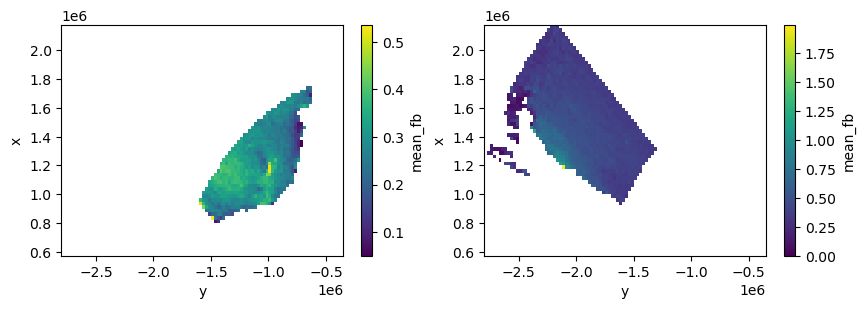

In [58]:
# Calculate spatial mean fb for each box
ATL20_masked_SWSbox = ATL20['mean_fb'].where(boxes_25['SWSbox'] == True).mean(dim=['x','y'])
ATL20_masked_WWSnocbox = ATL20['mean_fb'].where(boxes_25['WWSnocbox'] == True).mean(dim=['x','y'])

# plot to check correct boxes being made

fig, axs = plt.subplots(ncols=2, figsize=(10,3))

ATL20['mean_fb'].where(boxes_25['SWSbox'] == True).mean(dim='time').plot(ax=axs[0])
ATL20['mean_fb'].where(boxes_25['WWSnocbox'] == True).mean(dim='time').plot(ax=axs[1])

In [28]:
# Convert ATL20 data to pandas
ATL20_masked_SWSbox_df = ATL20_masked_SWSbox.to_pandas()
ATL20_masked_WWSnocbox_df = ATL20_masked_WWSnocbox.to_pandas()

In [64]:
# Subset the ice type dataset before masking with boxes otherwise it's computationally very slow

minx = min(boxes.x)
maxx = max(boxes.x)
miny = min(boxes.y)
maxy = max(boxes.y)

subset = resampled.sel(
    y=((resampled.y >= miny) & (resampled.y <= maxy)),
    x=((resampled.x >= miny) & (resampled.x <= maxx))
)

masked_SWSbox = subset.where(boxes['SWSbox'] == True).mean(dim=['x','y'])
masked_WWSnocbox = subset.where(boxes['WWSnocbox'] == True).mean(dim=['x','y'])

In [67]:
cols = ['MYI', 'FYI', 'YI']
masked_SWSbox_df = masked_SWSbox.to_pandas()
masked_WWSnocbox_df = masked_WWSnocbox.to_pandas()

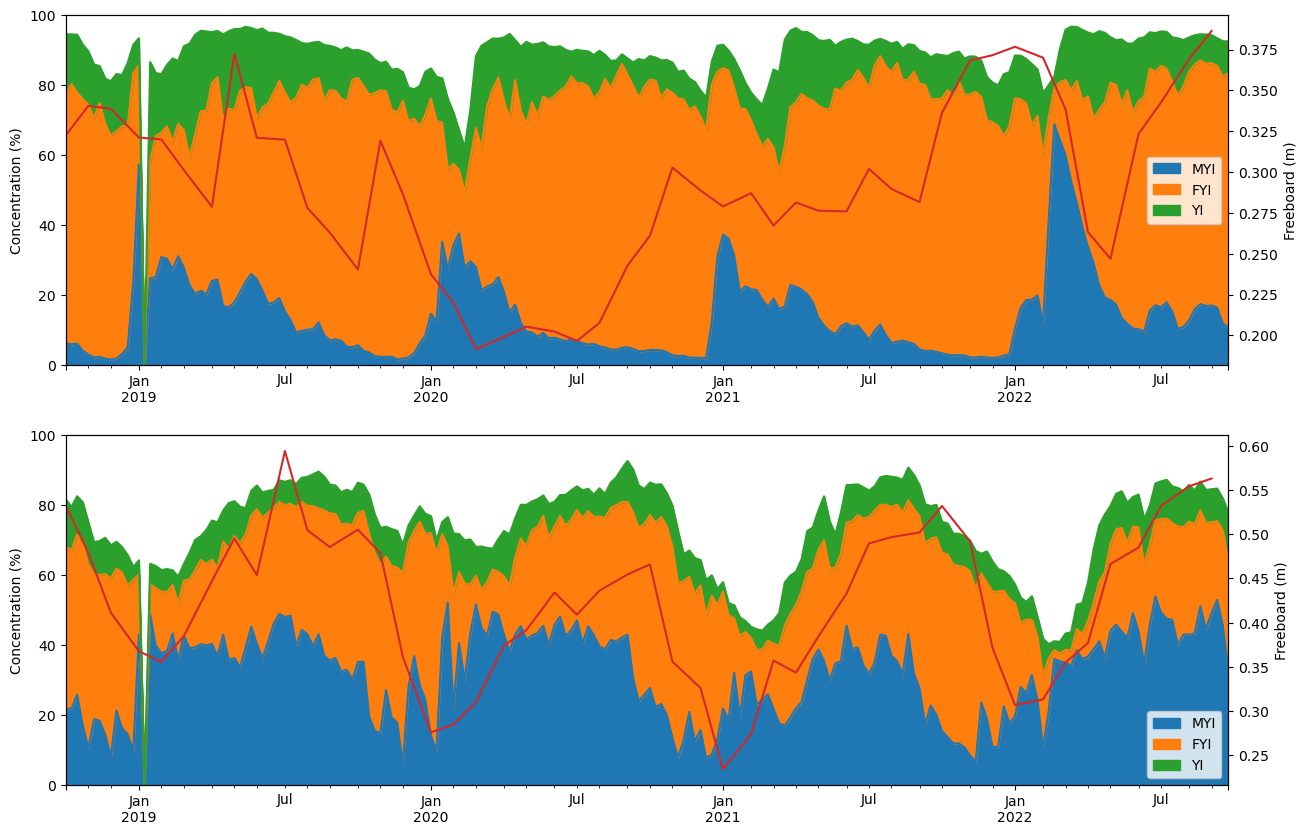

In [89]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
masked_SWSbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[0]).legend(loc='center')
ATL20_masked_SWSbox_df.plot(ax=ax[0], secondary_y=True)
ax[0].right_ax.set_ylabel('Freeboard (m)')
ax[0].set_ylabel('Concentration (%)')
ax[0].set_xlabel('')
masked_WWSnocbox_df[cols]['2018-10-01':'2022-10-01'].plot.area(ylim=(0,100), ax=ax[1]).legend(loc='center')
ATL20_masked_WWSnocbox_df.plot(ax=ax[1], secondary_y=True)#.legend(loc='lower right')
ax[1].right_ax.set_ylabel('Freeboard (m)')
ax[1].set_ylabel('Concentration (%)')
ax[1].set_xlabel('')
plt.savefig('/g/data/jk72/sc0554/icetypetimeseries.png', dpi=300, bbox_inches='tight')
